# Convolutional Neural Network

## Imports

### Library

In [ ]:
import tensorflow as tf

from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os

### Dataset

In [55]:
print("Loading CIFAR-10 dataset...")
(X_train_full, y_train_full), (X_test, y_test_labels_for_f1) = cifar10.load_data() # y_test is already (10000,1)

print(f"Original X_train_full shape: {X_train_full.shape}")
print(f"Original y_train_full shape: {y_train_full.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"Original y_test shape: {y_test_labels_for_f1.shape}")

Loading CIFAR-10 dataset...
Original X_train_full shape: (50000, 32, 32, 3)
Original y_train_full shape: (50000, 1)
Original X_test shape: (10000, 32, 32, 3)
Original y_test shape: (10000, 1)


In [3]:
MODEL_SAVE_DIR = 'cnn_models'
PLOT_SAVE_DIR = 'cnn_plots'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

## Preprocessing

In [56]:
# Normalize pixel values
X_train_full_norm = X_train_full.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

y_train_full_int = y_train_full.flatten()
y_test_int_for_f1 = y_test_labels_for_f1.flatten()

num_classes = 10

X_train_final, X_val_final, y_train_final_int, y_val_final_int = train_test_split(
    X_train_full_norm, y_train_full_int,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full_int
)

print(f"Final X_train_final shape: {X_train_final.shape}")
print(f"Final y_train_final_int shape: {y_train_final_int.shape}")
print(f"Final X_val_final shape: {X_val_final.shape}")
print(f"Final y_val_final_int shape: {y_val_final_int.shape}")
print(f"Final X_test_norm shape: {X_test_norm.shape}")
print(f"Final y_test_int_for_f1 shape: {y_test_int_for_f1.shape}")

Final X_train_final shape: (40000, 32, 32, 3)
Final y_train_final_int shape: (40000,)
Final X_val_final shape: (10000, 32, 32, 3)
Final y_val_final_int shape: (10000,)
Final X_test_norm shape: (10000, 32, 32, 3)
Final y_test_int_for_f1 shape: (10000,)


In [5]:
print("Sample train labels:", y_train_final_int[:5])
print("Sample validation labels:", y_val_final_int[:5])
print("Sample test labels:", y_test_int_for_f1[:5])

Sample train labels: [6 7 8 3 2]
Sample validation labels: [2 7 1 9 6]
Sample test labels: [3 8 8 0 6]


## Training with Keras

In [6]:
def define_alexnet_like_model(num_classes=10):
    model = models.Sequential(name="AlexNetLike_CIFAR10_Sparse")
    model.add(layers.Input(shape=(32, 32, 3), name='input_layer'))
    model.add(layers.Conv2D(48, (5, 5), strides=(1,1), activation='relu', kernel_initializer='he_uniform', padding='same', name='conv2d_1'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2,2), name='maxpool_1'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name='conv2d_2'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2,2), name='maxpool_2'))
    model.add(layers.Conv2D(192, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name='conv2d_3'))
    model.add(layers.Conv2D(192, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name='conv2d_4'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name='conv2d_5'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2,2), name='maxpool_3'))
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform', name='dense_1'))
    model.add(layers.Dropout(0.5, name='dropout_1'))
    model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name='dense_2'))
    model.add(layers.Dropout(0.5, name='dropout_2'))
    model.add(layers.Dense(num_classes, activation='softmax', name='dense_output'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
def plot_training_history(history, model_name_str, save_dir):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name_str} - Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name_str} - Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{model_name_str}_history.png"))
    plt.show()
    plt.close()

In [8]:
def train_and_evaluate_cnn_model(model_obj, X_train_data, y_train_data_int, X_val_data, y_val_data_int, X_test_data, y_test_data_int, model_name_str, epochs=50, batch_size=64): # Increased default epochs
    model_obj.summary()
    model_filepath = os.path.join(MODEL_SAVE_DIR, f'{model_name_str}_best_model.h5')
    weights_only_filepath = os.path.join(MODEL_SAVE_DIR, f'{model_name_str}_best.weights.h5')

    checkpoint_callback = ModelCheckpoint(
        filepath=model_filepath,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    print(f"\n--- Training Keras Model: {model_name_str} ---")
    history = model_obj.fit(
        X_train_data, y_train_data_int,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_data, y_val_data_int),
        callbacks=[checkpoint_callback, early_stopping_callback],
        verbose=1
    )

    print(f"\n--- Evaluating Keras Model: {model_name_str} (using best weights from training based on val_loss) ---")

    loss_val, accuracy_val = model_obj.evaluate(X_val_data, y_val_data_int, verbose=0)
    y_pred_probs_val = model_obj.predict(X_val_data, verbose=0)
    y_pred_classes_val = np.argmax(y_pred_probs_val, axis=1)
    f1_macro_val = f1_score(y_val_data_int.flatten(), y_pred_classes_val, average='macro', zero_division=0)
    print(f"Validation -> Loss: {loss_val:.4f}, Accuracy: {accuracy_val:.4f}, Macro F1: {f1_macro_val:.4f}")

    loss_test, accuracy_test = model_obj.evaluate(X_test_data, y_test_data_int, verbose=0)
    y_pred_probs_test = model_obj.predict(X_test_data, verbose=0)
    y_pred_classes_test = np.argmax(y_pred_probs_test, axis=1)
    f1_macro_test = f1_score(y_test_data_int.flatten(), y_pred_classes_test, average='macro', zero_division=0)
    print(f"Test -> Loss: {loss_test:.4f}, Accuracy: {accuracy_test:.4f}, Macro F1: {f1_macro_test:.4f}")

    print(f"Best Keras model (full) based on val_loss saved by ModelCheckpoint to: {model_filepath}")

    model_obj.save_weights(weights_only_filepath)
    print(f"Best Keras model weights (only) also saved to: {weights_only_filepath}")

    return history, f1_macro_val, f1_macro_test

### Baseline Model

Model: "AlexNetLike_CIFAR10_Sparse"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 48)     │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 192)      │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,392,458 (5.31 MB)

 Trainable params: 1,392,458 (5.31 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: AlexNetLike_CIFAR10_Sparse_Baseline ---
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2093 - loss: 2.0891
Epoch 1: val_loss improved from inf to 1.41770, saving model to cnn_models/AlexNetLike_CIFAR10_Sparse_Baseline_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.2095 - loss: 2.0887 - val_accuracy: 0.4822 - val_loss: 1.4177
Epoch 2/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4802 - loss: 1.4300
Epoch 2: val_loss improved from 1.41770 to 1.21093, saving model to cnn_models/AlexNetLike_CIFAR10_Sparse_Baseline_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.4804 - loss: 1.4295 - val_accuracy: 0.5565 - val_loss: 1.2109
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5885 - loss: 1.1658
Epoch 3: val_loss improved from 1.21093 to 1.05819, saving model to cnn_models/AlexNetLike_CIFAR10_Sparse_Baseline_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5886 - loss: 1.1658 - val_accuracy: 0.6181 - val_loss: 1.0582
Epoch 4/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6515 - loss: 0.9964
Epoch 4: val_loss improved from 1.05819 to 0.95934, saving model to cnn_models/AlexNetLike_CIFAR10_Sparse_Baseline_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6516 - loss: 0.9964 - val_accuracy: 0.6671 - val_loss: 0.9593
Epoch 5/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6981 - loss: 0.8737
Epoch 5: val_loss improved from 0.95934 to 0.90280, saving model to cnn_models/AlexNetLike_CIFAR10_Sparse_Baseline_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6981 - loss: 0.8737 - val_accuracy: 0.6860 - val_loss: 0.9028
Epoch 6/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7302 - loss: 0.7755
Epoch 6: val_loss improved from 0.90280 to 0.88191, saving model to cnn_models/AlexNetLike_CIFAR10_Sparse_Baseline_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7302 - loss: 0.7754 - val_accuracy: 0.6982 - val_loss: 0.8819
Epoch 7/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7673 - loss: 0.6738
Epoch 7: val_loss improved from 0.88191 to 0.81775, saving model to cnn_models/AlexNetLike_CIFAR10_Sparse_Baseline_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7672 - loss: 0.6739 - val_accuracy: 0.7231 - val_loss: 0.8178
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7994 - loss: 0.5931
Epoch 8: val_loss did not improve from 0.81775
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7994 - loss: 0.5931 - val_accuracy: 0.7060 - val_loss: 0.8535
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8237 - loss: 0.5279
Epoch 9: val_loss did not improve from 0.81775
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8237 - loss: 0.5279 - val_accuracy: 0.7246 - val_loss: 0.8657
Epoch 10/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8419 - loss: 0.4617
Epoch 10: val_loss did not improve from 0.81775
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8418 - loss: 0.4619 - val_accuracy: 0.7286 - val_loss: 0.8959
Epoch 11/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8559 - loss: 0.4224
Epoch 11: val_loss did not improve fro

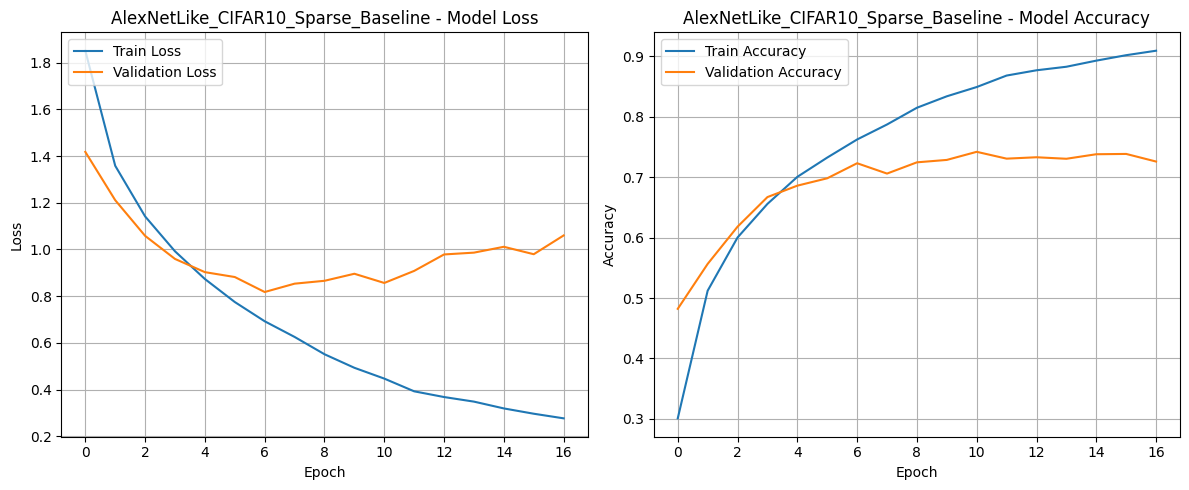


AlexNet-like Baseline CNN Model - Validation Macro F1: 0.7252
AlexNet-like Baseline CNN Model - Test Macro F1: 0.7249

Sample Test Predictions from AlexNet-like Baseline Model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
Probabilities:
 [[2.1315280e-03 6.1472511e-04 2.5362620e-02 5.0727040e-01 6.1947410e-03
  4.2246458e-01 1.1901999e-02 1.9563381e-02 1.3455435e-03 3.1504193e-03]
 [1.0330628e-04 3.2311134e-02 1.3484358e-08 4.4817444e-08 2.8909145e-10
  5.0963106e-10 1.9435857e-08 3.1758916e-13 9.6739107e-01 1.9444589e-04]
 [1.7737482e-01 1.7160060e-02 9.6319243e-03 6.2424336e-03 3.5384146e-03
  1.0171137e-03 1.4696500e-03 4.0260673e-04 7.6060736e-01 2.2555640e-02]
 [6.2405306e-01 2.3611110e-02 1.2817352e-01 3.6923435e-02 3.2661892e-02
  6.2998426e-03 6.6818702e-03 2.7852873e-03 1.2819166e-01 1.0618355e-02]
 [2.4226072e-06 4.3090995e-06 1.1361919e-02 6.9223996e-03 1.4337583e-02
  2.0343164e-04 9.6716559e-01 5.7151749e-07 3.4407159e-07 1.4988625e-06]]
Predicted Classes: [3 8 8 0 6]
True Class

In [9]:
alexnet_baseline_model = define_alexnet_like_model(num_classes=num_classes)

alexnet_history, alexnet_f1_val, alexnet_f1_test = train_and_evaluate_cnn_model(
    model_obj=alexnet_baseline_model,
    X_train_data=X_train_final, y_train_data_int=y_train_final_int,
    X_val_data=X_val_final, y_val_data_int=y_val_final_int,
    X_test_data=X_test_norm, y_test_data_int=y_test_int_for_f1,
    model_name_str="AlexNetLike_CIFAR10_Sparse_Baseline",
    epochs=50,
    batch_size=64
)

plot_training_history(alexnet_history, "AlexNetLike_CIFAR10_Sparse_Baseline", PLOT_SAVE_DIR)

print(f"\nAlexNet-like Baseline CNN Model - Validation Macro F1: {alexnet_f1_val:.4f}")
print(f"AlexNet-like Baseline CNN Model - Test Macro F1: {alexnet_f1_test:.4f}")

print("\nSample Test Predictions from AlexNet-like Baseline Model:")
if len(X_test_norm) > 0:
    keras_test_preds_probs = alexnet_baseline_model.predict(X_test_norm[:5])
    keras_test_preds_classes = np.argmax(keras_test_preds_probs, axis=1)
    print("Probabilities:\n", keras_test_preds_probs)
    print("Predicted Classes:", keras_test_preds_classes)
    print("True Classes:     ", y_test_int_for_f1[:5])
else:
    print("X_test_norm is empty.")

In [10]:
def build_experimental_cnn_model(num_conv_layers, filters_list_per_layer, kernel_size_tuple, pooling_type, num_classes=10, dense_units=128, dropout_rate=0.5):
    model_name_parts = [
        f"Conv{num_conv_layers}",
        f"Filters{'_'.join(map(str, filters_list_per_layer))}", # Assumes filters_list_per_layer matches num_conv_layers
        f"Kernel{kernel_size_tuple[0]}",
        f"Pool{pooling_type}"
    ]
    model = models.Sequential(name='_'.join(model_name_parts))
    model.add(layers.Input(shape=(32, 32, 3), name='input_layer'))

    if len(filters_list_per_layer) != num_conv_layers:
        raise ValueError(f"Length of filters_list_per_layer ({len(filters_list_per_layer)}) must match num_conv_layers ({num_conv_layers}).")

    for i in range(num_conv_layers):
        model.add(layers.Conv2D(filters_list_per_layer[i], kernel_size_tuple, activation='relu', kernel_initializer='he_uniform', padding='same', name=f'conv2d_{i+1}'))
        # Common practice: Pool after a conv layer or a block of conv layers.
        # Here, we'll pool after each conv layer for simplicity in this experimental setup.
        # You can make this more complex (e.g., pool only after specific layers).
        if pooling_type == 'max':
            model.add(layers.MaxPooling2D((2, 2), name=f'maxpool_{i+1}')) # Stride defaults to pool_size
        elif pooling_type == 'avg':
            model.add(layers.AveragePooling2D((2, 2), name=f'avgpool_{i+1}'))
        # No pooling layer if pooling_type is None or unrecognized

    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(dense_units, activation='relu', kernel_initializer='he_uniform', name=f'dense_{dense_units}'))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate, name='dropout_fc'))
    model.add(layers.Dense(num_classes, activation='softmax', name='dense_output'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # You can also experiment with learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

### Experiment: Number of Conv Layers


Building model: CNN_NumLayers_1 with filters: [64]


Model: "Conv1_Filters64_Kernel3_Poolmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,100,362 (8.01 MB)

 Trainable params: 2,100,362 (8.01 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: CNN_NumLayers_1 ---
Epoch 1/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1189 - loss: 2.4927
Epoch 1: val_loss improved from inf to 2.06304, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.1191 - loss: 2.4907 - val_accuracy: 0.2277 - val_loss: 2.0630
Epoch 2/50
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1700 - loss: 2.1499
Epoch 2: val_loss improved from 2.06304 to 1.90209, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1702 - loss: 2.1493 - val_accuracy: 0.3036 - val_loss: 1.9021
Epoch 3/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2163 - loss: 1.9915
Epoch 3: val_loss improved from 1.90209 to 1.78133, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2163 - loss: 1.9913 - val_accuracy: 0.3390 - val_loss: 1.7813
Epoch 4/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2229 - loss: 1.9450
Epoch 4: val_loss improved from 1.78133 to 1.73510, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2229 - loss: 1.9450 - val_accuracy: 0.3559 - val_loss: 1.7351
Epoch 5/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2278 - loss: 1.9328
Epoch 5: val_loss improved from 1.73510 to 1.63988, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2279 - loss: 1.9326 - val_accuracy: 0.3997 - val_loss: 1.6399
Epoch 6/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2806 - loss: 1.8299
Epoch 6: val_loss improved from 1.63988 to 1.49735, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2807 - loss: 1.8296 - val_accuracy: 0.4710 - val_loss: 1.4974
Epoch 7/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3343 - loss: 1.7102
Epoch 7: val_loss improved from 1.49735 to 1.43485, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3344 - loss: 1.7101 - val_accuracy: 0.5100 - val_loss: 1.4349
Epoch 8/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3616 - loss: 1.6445
Epoch 8: val_loss improved from 1.43485 to 1.38660, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3616 - loss: 1.6445 - val_accuracy: 0.5233 - val_loss: 1.3866
Epoch 9/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3877 - loss: 1.6025
Epoch 9: val_loss improved from 1.38660 to 1.34939, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3877 - loss: 1.6025 - val_accuracy: 0.5436 - val_loss: 1.3494
Epoch 10/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4020 - loss: 1.5487
Epoch 10: val_loss improved from 1.34939 to 1.32144, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4020 - loss: 1.5488 - val_accuracy: 0.5554 - val_loss: 1.3214
Epoch 11/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4082 - loss: 1.5229
Epoch 11: val_loss improved from 1.32144 to 1.27702, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4082 - loss: 1.5229 - val_accuracy: 0.5569 - val_loss: 1.2770
Epoch 12/50
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4155 - loss: 1.4873
Epoch 12: val_loss improved from 1.27702 to 1.27505, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4155 - loss: 1.4875 - val_accuracy: 0.5619 - val_loss: 1.2751
Epoch 13/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4209 - loss: 1.4804
Epoch 13: val_loss improved from 1.27505 to 1.23705, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4209 - loss: 1.4804 - val_accuracy: 0.5717 - val_loss: 1.2371
Epoch 14/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4332 - loss: 1.4607
Epoch 14: val_loss improved from 1.23705 to 1.22452, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4332 - loss: 1.4607 - val_accuracy: 0.5779 - val_loss: 1.2245
Epoch 15/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4360 - loss: 1.4432
Epoch 15: val_loss improved from 1.22452 to 1.21948, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4360 - loss: 1.4432 - val_accuracy: 0.5787 - val_loss: 1.2195
Epoch 16/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4480 - loss: 1.4236
Epoch 16: val_loss did not improve from 1.21948
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4480 - loss: 1.4237 - val_accuracy: 0.5684 - val_loss: 1.2219
Epoch 17/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4492 - loss: 1.4079
Epoch 17: val_loss did not improve from 1.21948
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4491 - loss: 1.4080 - val_accuracy: 0.5772 - val_loss: 1.2325
Epoch 18/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4548 - loss: 1.3940
Epoch 18: val_loss improved from 1.21948 to 1.21711, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4547 - loss: 1.3941 - val_accuracy: 0.5785 - val_loss: 1.2171
Epoch 19/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4615 - loss: 1.3865
Epoch 19: val_loss improved from 1.21711 to 1.20268, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4615 - loss: 1.3865 - val_accuracy: 0.5871 - val_loss: 1.2027
Epoch 20/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4599 - loss: 1.3775
Epoch 20: val_loss did not improve from 1.20268
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4599 - loss: 1.3775 - val_accuracy: 0.5813 - val_loss: 1.2124
Epoch 21/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4614 - loss: 1.3692
Epoch 21: val_loss did not improve from 1.20268
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4614 - loss: 1.3693 - val_accuracy: 0.5732 - val_loss: 1.2371
Epoch 22/50
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4692 - loss: 1.3514
Epoch 22: val_loss improved from 1.20268 to 1.20248, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4691 - loss: 1.3516 - val_accuracy: 0.5900 - val_loss: 1.2025
Epoch 23/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4693 - loss: 1.3456
Epoch 23: val_loss did not improve from 1.20248
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4693 - loss: 1.3456 - val_accuracy: 0.5860 - val_loss: 1.2146
Epoch 24/50
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4688 - loss: 1.3383
Epoch 24: val_loss improved from 1.20248 to 1.19312, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4687 - loss: 1.3383 - val_accuracy: 0.5922 - val_loss: 1.1931
Epoch 25/50
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4762 - loss: 1.3224
Epoch 25: val_loss did not improve from 1.19312
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4761 - loss: 1.3225 - val_accuracy: 0.5816 - val_loss: 1.2017
Epoch 26/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4808 - loss: 1.3215
Epoch 26: val_loss improved from 1.19312 to 1.18156, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4808 - loss: 1.3216 - val_accuracy: 0.5952 - val_loss: 1.1816
Epoch 27/50
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4800 - loss: 1.3102
Epoch 27: val_loss did not improve from 1.18156
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4799 - loss: 1.3104 - val_accuracy: 0.5792 - val_loss: 1.2014
Epoch 28/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4869 - loss: 1.3033
Epoch 28: val_loss did not improve from 1.18156
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4868 - loss: 1.3033 - val_accuracy: 0.5882 - val_loss: 1.1825
Epoch 29/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4871 - loss: 1.2992
Epoch 29: val_loss improved from 1.18156 to 1.17703, saving model to cnn_models/CNN_NumLayers_1_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4871 - loss: 1.2992 - val_accuracy: 0.5933 - val_loss: 1.1770
Epoch 30/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4853 - loss: 1.2880
Epoch 30: val_loss did not improve from 1.17703
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4853 - loss: 1.2881 - val_accuracy: 0.5956 - val_loss: 1.1843
Epoch 31/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4956 - loss: 1.2727
Epoch 31: val_loss did not improve from 1.17703
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4955 - loss: 1.2728 - val_accuracy: 0.5866 - val_loss: 1.2058
Epoch 32/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4986 - loss: 1.2705
Epoch 32: val_loss did not improve from 1.17703
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4985 - loss: 1.2705 - val_accuracy: 0.5843 - val_loss: 1.2044
Epoch 33/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4895 - loss: 1.2765
Epoch 33: val_loss did not improve from 

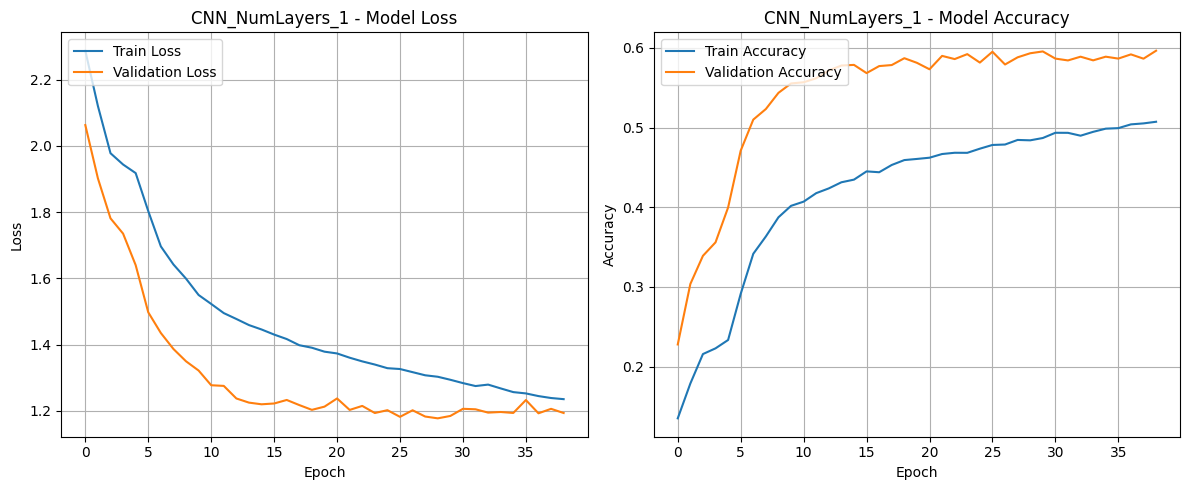


Building model: CNN_NumLayers_2 with filters: [64, 64]


Model: "Conv2_Filters64_64_Kernel3_Poolmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 564,426 (2.15 MB)

 Trainable params: 564,426 (2.15 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: CNN_NumLayers_2 ---
Epoch 1/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2809 - loss: 2.0082
Epoch 1: val_loss improved from inf to 1.36154, saving model to cnn_models/CNN_NumLayers_2_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2822 - loss: 2.0042 - val_accuracy: 0.5205 - val_loss: 1.3615
Epoch 2/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4728 - loss: 1.4592
Epoch 2: val_loss improved from 1.36154 to 1.22195, saving model to cnn_models/CNN_NumLayers_2_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4730 - loss: 1.4589 - val_accuracy: 0.5665 - val_loss: 1.2220
Epoch 3/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5303 - loss: 1.3059
Epoch 3: val_loss improved from 1.22195 to 1.15486, saving model to cnn_models/CNN_NumLayers_2_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5303 - loss: 1.3057 - val_accuracy: 0.5938 - val_loss: 1.1549
Epoch 4/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5661 - loss: 1.2123
Epoch 4: val_loss improved from 1.15486 to 1.03743, saving model to cnn_models/CNN_NumLayers_2_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5661 - loss: 1.2122 - val_accuracy: 0.6311 - val_loss: 1.0374
Epoch 5/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5948 - loss: 1.1336
Epoch 5: val_loss improved from 1.03743 to 1.00101, saving model to cnn_models/CNN_NumLayers_2_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5948 - loss: 1.1335 - val_accuracy: 0.6483 - val_loss: 1.0010
Epoch 6/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6223 - loss: 1.0508
Epoch 6: val_loss improved from 1.00101 to 0.98144, saving model to cnn_models/CNN_NumLayers_2_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6223 - loss: 1.0509 - val_accuracy: 0.6580 - val_loss: 0.9814
Epoch 7/50
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6512 - loss: 0.9859
Epoch 7: val_loss improved from 0.98144 to 0.92721, saving model to cnn_models/CNN_NumLayers_2_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6511 - loss: 0.9861 - val_accuracy: 0.6759 - val_loss: 0.9272
Epoch 8/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6658 - loss: 0.9511
Epoch 8: val_loss improved from 0.92721 to 0.90014, saving model to cnn_models/CNN_NumLayers_2_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6658 - loss: 0.9511 - val_accuracy: 0.6867 - val_loss: 0.9001
Epoch 9/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6792 - loss: 0.9061
Epoch 9: val_loss did not improve from 0.90014
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6792 - loss: 0.9061 - val_accuracy: 0.6742 - val_loss: 0.9297
Epoch 10/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6937 - loss: 0.8631
Epoch 10: val_loss improved from 0.90014 to 0.88825, saving model to cnn_models/CNN_NumLayers_2_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6937 - loss: 0.8631 - val_accuracy: 0.6915 - val_loss: 0.8883
Epoch 11/50
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7045 - loss: 0.8273
Epoch 11: val_loss improved from 0.88825 to 0.88770, saving model to cnn_models/CNN_NumLayers_2_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7045 - loss: 0.8273 - val_accuracy: 0.6951 - val_loss: 0.8877
Epoch 12/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7171 - loss: 0.7902
Epoch 12: val_loss improved from 0.88770 to 0.87183, saving model to cnn_models/CNN_NumLayers_2_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7171 - loss: 0.7903 - val_accuracy: 0.7046 - val_loss: 0.8718
Epoch 13/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7298 - loss: 0.7527
Epoch 13: val_loss did not improve from 0.87183
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7297 - loss: 0.7529 - val_accuracy: 0.6985 - val_loss: 0.8862
Epoch 14/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7367 - loss: 0.7275
Epoch 14: val_loss did not improve from 0.87183
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7366 - loss: 0.7277 - val_accuracy: 0.7051 - val_loss: 0.8743
Epoch 15/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7437 - loss: 0.7061
Epoch 15: val_loss did not improve from 0.87183
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7437 - loss: 0.7062 - val_accuracy: 0.6985 - val_loss: 0.8936
Epoch 16/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7577 - loss: 0.6707
Epoch 16: val_loss did not improve from 

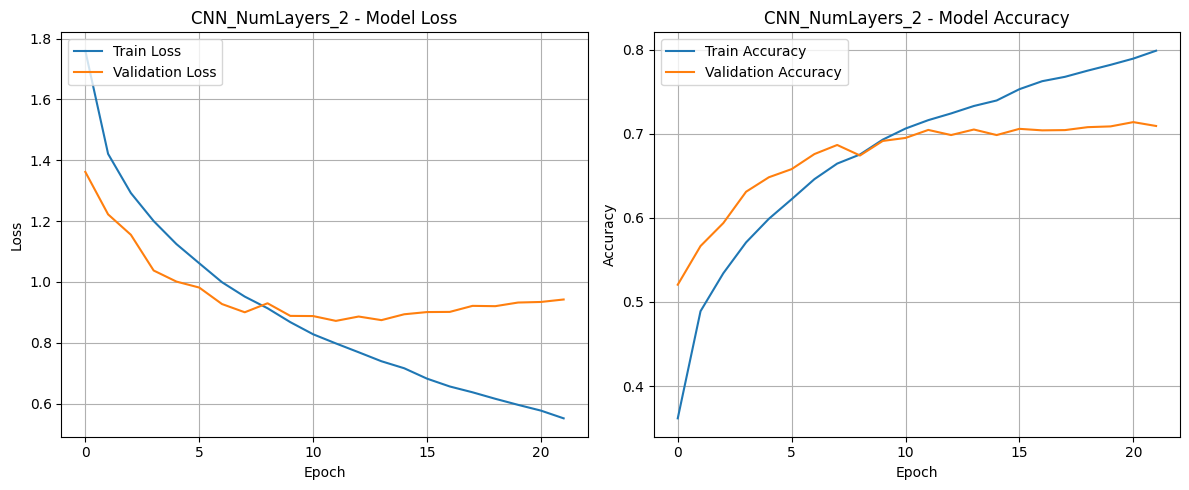


Building model: CNN_NumLayers_3 with filters: [64, 64, 64]


Model: "Conv3_Filters64_64_64_Kernel3_Poolmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,138 (813.04 KB)

 Trainable params: 208,138 (813.04 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: CNN_NumLayers_3 ---
Epoch 1/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3029 - loss: 1.9035
Epoch 1: val_loss improved from inf to 1.36396, saving model to cnn_models/CNN_NumLayers_3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3035 - loss: 1.9020 - val_accuracy: 0.5086 - val_loss: 1.3640
Epoch 2/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5157 - loss: 1.3410
Epoch 2: val_loss improved from 1.36396 to 1.10053, saving model to cnn_models/CNN_NumLayers_3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5160 - loss: 1.3402 - val_accuracy: 0.6065 - val_loss: 1.1005
Epoch 3/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5918 - loss: 1.1452
Epoch 3: val_loss improved from 1.10053 to 0.96804, saving model to cnn_models/CNN_NumLayers_3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5919 - loss: 1.1450 - val_accuracy: 0.6642 - val_loss: 0.9680
Epoch 4/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6509 - loss: 1.0064
Epoch 4: val_loss improved from 0.96804 to 0.92211, saving model to cnn_models/CNN_NumLayers_3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6510 - loss: 1.0062 - val_accuracy: 0.6760 - val_loss: 0.9221
Epoch 5/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6744 - loss: 0.9197
Epoch 5: val_loss improved from 0.92211 to 0.86030, saving model to cnn_models/CNN_NumLayers_3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6745 - loss: 0.9197 - val_accuracy: 0.6977 - val_loss: 0.8603
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7016 - loss: 0.8489
Epoch 6: val_loss did not improve from 0.86030
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7016 - loss: 0.8489 - val_accuracy: 0.7006 - val_loss: 0.8711
Epoch 7/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7222 - loss: 0.7852
Epoch 7: val_loss improved from 0.86030 to 0.85094, saving model to cnn_models/CNN_NumLayers_3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7222 - loss: 0.7853 - val_accuracy: 0.7054 - val_loss: 0.8509
Epoch 8/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7442 - loss: 0.7353
Epoch 8: val_loss improved from 0.85094 to 0.81241, saving model to cnn_models/CNN_NumLayers_3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7442 - loss: 0.7353 - val_accuracy: 0.7148 - val_loss: 0.8124
Epoch 9/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7562 - loss: 0.6865
Epoch 9: val_loss improved from 0.81241 to 0.79771, saving model to cnn_models/CNN_NumLayers_3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7562 - loss: 0.6867 - val_accuracy: 0.7261 - val_loss: 0.7977
Epoch 10/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7688 - loss: 0.6481
Epoch 10: val_loss did not improve from 0.79771
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7688 - loss: 0.6482 - val_accuracy: 0.7237 - val_loss: 0.8094
Epoch 11/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7824 - loss: 0.6130
Epoch 11: val_loss did not improve from 0.79771
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7823 - loss: 0.6130 - val_accuracy: 0.7186 - val_loss: 0.8487
Epoch 12/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7934 - loss: 0.5925
Epoch 12: val_loss did not improve from 0.79771
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7934 - loss: 0.5925 - val_accuracy: 0.7346 - val_loss: 0.8062
Epoch 13/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8074 - loss: 0.5472
Epoch 13: val_loss did not improve from 

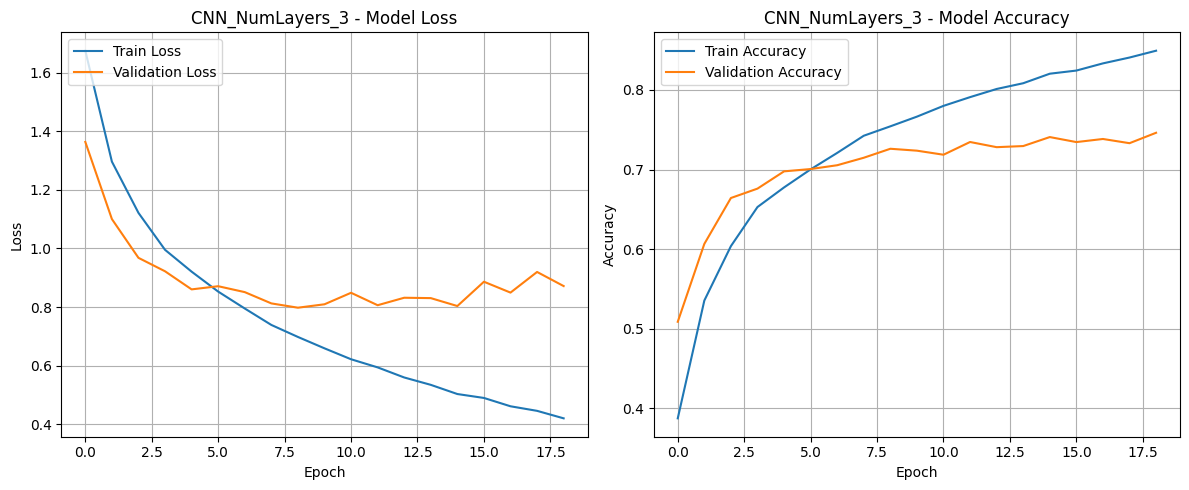

In [13]:
results_num_layers = []
# Ensure num_classes is correctly determined from your data (e.g., from Cell 3)
# num_classes = len(np.unique(y_train_full_int)) # y_train_full_int from Cell 3

# Define base filter configurations for each layer count scenario
# For simplicity, we can repeat a filter size or have a growing scheme
# For this experiment, let's use a fixed reasonable filter size for new layers.
default_filters_for_experiment = [64] # Use 64 filters for all layers in this specific experiment
default_kernel_size = (3,3)
default_pooling = 'max'

all_histories_num_layers = {}

for n_layers in [1, 2, 3]:
    # Create a filter list for the current number of layers
    # Example: if n_layers = 3, filters_list = [64, 64, 64]
    current_filters_list = default_filters_for_experiment * n_layers
    # If you want varying filters, e.g. [32], [32,64], [32,64,128], you'd define them differently:
    # if n_layers == 1: current_filters_list = [32]
    # elif n_layers == 2: current_filters_list = [32, 64]
    # elif n_layers == 3: current_filters_list = [32, 64, 128]

    model_name = f"CNN_NumLayers_{n_layers}"
    print(f"\nBuilding model: {model_name} with filters: {current_filters_list}")

    model = build_experimental_cnn_model(
        num_conv_layers=n_layers,
        filters_list_per_layer=current_filters_list,
        kernel_size_tuple=default_kernel_size,
        pooling_type=default_pooling,
        num_classes=num_classes # Make sure num_classes is defined
    )

    history, f1_val, f1_test = train_and_evaluate_cnn_model(
        model, X_train_final, y_train_final_int, X_val_final, y_val_final_int, X_test_norm, y_test_int_for_f1,
        model_name, epochs=50, batch_size=64
    )
    plot_training_history(history, model_name, PLOT_SAVE_DIR)

    all_histories_num_layers[model_name] = history
    results_num_layers.append({'name': model_name, 'val_f1': f1_val, 'test_f1': f1_test})

### Experiment: Number of Filters per Layer


Building model: CNN_Filters_32_32


Model: "Conv2_Filters32_32_Kernel3_Poolmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,706 (1.04 MB)

 Trainable params: 273,706 (1.04 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: CNN_Filters_32_32 ---
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3073 - loss: 1.9005
Epoch 1: val_loss improved from inf to 1.29079, saving model to cnn_models/CNN_Filters_32_32_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3074 - loss: 1.9002 - val_accuracy: 0.5401 - val_loss: 1.2908
Epoch 2/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5183 - loss: 1.3521
Epoch 2: val_loss improved from 1.29079 to 1.15740, saving model to cnn_models/CNN_Filters_32_32_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5185 - loss: 1.3516 - val_accuracy: 0.5835 - val_loss: 1.1574
Epoch 3/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5816 - loss: 1.1849
Epoch 3: val_loss improved from 1.15740 to 1.01813, saving model to cnn_models/CNN_Filters_32_32_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5816 - loss: 1.1846 - val_accuracy: 0.6454 - val_loss: 1.0181
Epoch 4/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6155 - loss: 1.0962
Epoch 4: val_loss improved from 1.01813 to 0.96943, saving model to cnn_models/CNN_Filters_32_32_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6155 - loss: 1.0962 - val_accuracy: 0.6642 - val_loss: 0.9694
Epoch 5/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6353 - loss: 1.0328
Epoch 5: val_loss improved from 0.96943 to 0.96428, saving model to cnn_models/CNN_Filters_32_32_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6353 - loss: 1.0329 - val_accuracy: 0.6633 - val_loss: 0.9643
Epoch 6/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6500 - loss: 0.9885
Epoch 6: val_loss improved from 0.96428 to 0.92535, saving model to cnn_models/CNN_Filters_32_32_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6500 - loss: 0.9885 - val_accuracy: 0.6716 - val_loss: 0.9253
Epoch 7/50
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6757 - loss: 0.9317
Epoch 7: val_loss improved from 0.92535 to 0.90033, saving model to cnn_models/CNN_Filters_32_32_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6756 - loss: 0.9318 - val_accuracy: 0.6856 - val_loss: 0.9003
Epoch 8/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6867 - loss: 0.8935
Epoch 8: val_loss improved from 0.90033 to 0.88792, saving model to cnn_models/CNN_Filters_32_32_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6867 - loss: 0.8935 - val_accuracy: 0.6891 - val_loss: 0.8879
Epoch 9/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6968 - loss: 0.8608
Epoch 9: val_loss did not improve from 0.88792
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6967 - loss: 0.8608 - val_accuracy: 0.6871 - val_loss: 0.8933
Epoch 10/50
610/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7057 - loss: 0.8257
Epoch 10: val_loss did not improve from 0.88792
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7057 - loss: 0.8258 - val_accuracy: 0.6907 - val_loss: 0.8912
Epoch 11/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7236 - loss: 0.7804
Epoch 11: val_loss improved from 0.88792 to 0.88365, saving model to cnn_models/CNN_Filters_32_32_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7236 - loss: 0.7804 - val_accuracy: 0.6921 - val_loss: 0.8836
Epoch 12/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7292 - loss: 0.7556
Epoch 12: val_loss improved from 0.88365 to 0.86763, saving model to cnn_models/CNN_Filters_32_32_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7292 - loss: 0.7556 - val_accuracy: 0.6955 - val_loss: 0.8676
Epoch 13/50
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7409 - loss: 0.7352
Epoch 13: val_loss did not improve from 0.86763
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7408 - loss: 0.7353 - val_accuracy: 0.6971 - val_loss: 0.8908
Epoch 14/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7445 - loss: 0.7097
Epoch 14: val_loss did not improve from 0.86763
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7445 - loss: 0.7097 - val_accuracy: 0.7030 - val_loss: 0.8705
Epoch 15/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7552 - loss: 0.6836
Epoch 15: val_loss did not improve from 0.86763
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7551 - loss: 0.6837 - val_accuracy: 0.6976 - val_loss: 0.8991
Epoch 16/50
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7592 - loss: 0.6694
Epoch 16: val_loss did not improve from 

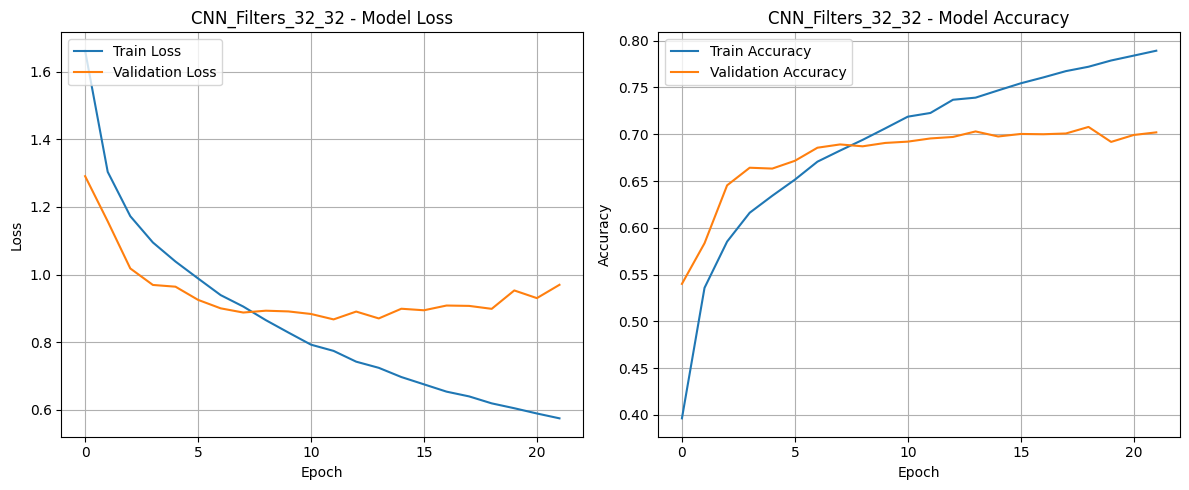


Building model: CNN_Filters_32_64


Model: "Conv2_Filters32_64_Kernel3_Poolmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: CNN_Filters_32_64 ---
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2283 - loss: 2.0756
Epoch 1: val_loss improved from inf to 1.52069, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2284 - loss: 2.0753 - val_accuracy: 0.4841 - val_loss: 1.5207
Epoch 2/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3786 - loss: 1.6359
Epoch 2: val_loss improved from 1.52069 to 1.32966, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3788 - loss: 1.6354 - val_accuracy: 0.5519 - val_loss: 1.3297
Epoch 3/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4253 - loss: 1.5274
Epoch 3: val_loss improved from 1.32966 to 1.27853, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4255 - loss: 1.5270 - val_accuracy: 0.5659 - val_loss: 1.2785
Epoch 4/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4674 - loss: 1.4171
Epoch 4: val_loss improved from 1.27853 to 1.18034, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4675 - loss: 1.4170 - val_accuracy: 0.6011 - val_loss: 1.1803
Epoch 5/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4899 - loss: 1.3645
Epoch 5: val_loss improved from 1.18034 to 1.09624, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4899 - loss: 1.3646 - val_accuracy: 0.6159 - val_loss: 1.0962
Epoch 6/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5047 - loss: 1.3186
Epoch 6: val_loss improved from 1.09624 to 1.07014, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5048 - loss: 1.3185 - val_accuracy: 0.6220 - val_loss: 1.0701
Epoch 7/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5327 - loss: 1.2561
Epoch 7: val_loss improved from 1.07014 to 1.04821, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5326 - loss: 1.2561 - val_accuracy: 0.6384 - val_loss: 1.0482
Epoch 8/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5386 - loss: 1.2268
Epoch 8: val_loss improved from 1.04821 to 1.04582, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5387 - loss: 1.2268 - val_accuracy: 0.6370 - val_loss: 1.0458
Epoch 9/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5585 - loss: 1.1848
Epoch 9: val_loss improved from 1.04582 to 0.99689, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5585 - loss: 1.1849 - val_accuracy: 0.6557 - val_loss: 0.9969
Epoch 10/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5734 - loss: 1.1548
Epoch 10: val_loss did not improve from 0.99689
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5734 - loss: 1.1548 - val_accuracy: 0.6508 - val_loss: 1.0066
Epoch 11/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 1.1009
Epoch 11: val_loss improved from 0.99689 to 0.97005, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5931 - loss: 1.1008 - val_accuracy: 0.6680 - val_loss: 0.9700
Epoch 12/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6046 - loss: 1.0683
Epoch 12: val_loss improved from 0.97005 to 0.96976, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6046 - loss: 1.0683 - val_accuracy: 0.6605 - val_loss: 0.9698
Epoch 13/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6137 - loss: 1.0365
Epoch 13: val_loss improved from 0.96976 to 0.95833, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6137 - loss: 1.0365 - val_accuracy: 0.6705 - val_loss: 0.9583
Epoch 14/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6235 - loss: 1.0053
Epoch 14: val_loss improved from 0.95833 to 0.94651, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6235 - loss: 1.0054 - val_accuracy: 0.6728 - val_loss: 0.9465
Epoch 15/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6401 - loss: 0.9658
Epoch 15: val_loss improved from 0.94651 to 0.91508, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6401 - loss: 0.9658 - val_accuracy: 0.6852 - val_loss: 0.9151
Epoch 16/50
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6640 - loss: 0.9251
Epoch 16: val_loss did not improve from 0.91508
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6640 - loss: 0.9254 - val_accuracy: 0.6857 - val_loss: 0.9173
Epoch 17/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6688 - loss: 0.8929
Epoch 17: val_loss improved from 0.91508 to 0.90373, saving model to cnn_models/CNN_Filters_32_64_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6688 - loss: 0.8930 - val_accuracy: 0.6872 - val_loss: 0.9037
Epoch 18/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6838 - loss: 0.8642
Epoch 18: val_loss did not improve from 0.90373
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6838 - loss: 0.8643 - val_accuracy: 0.6909 - val_loss: 0.9139
Epoch 19/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6914 - loss: 0.8345
Epoch 19: val_loss did not improve from 0.90373
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6914 - loss: 0.8345 - val_accuracy: 0.6875 - val_loss: 0.9213
Epoch 20/50
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6979 - loss: 0.8155
Epoch 20: val_loss did not improve from 0.90373
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6979 - loss: 0.8155 - val_accuracy: 0.6944 - val_loss: 0.9246
Epoch 21/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7093 - loss: 0.7782
Epoch 21: val_loss did not improve from 

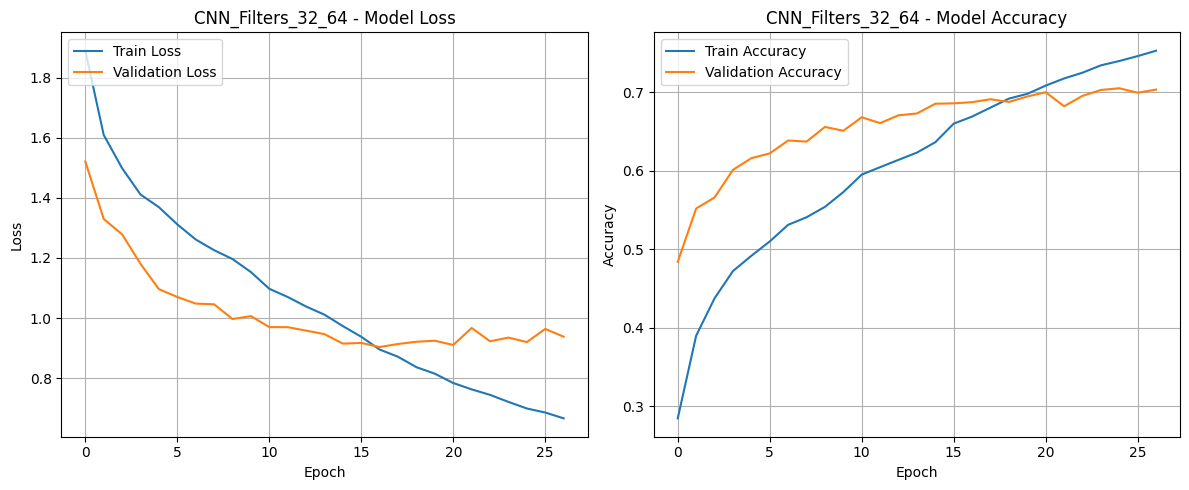


Building model: CNN_Filters_64_128


Model: "Conv2_Filters64_128_Kernel3_Poolmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,642 (4.29 MB)

 Trainable params: 1,125,642 (4.29 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: CNN_Filters_64_128 ---
Epoch 1/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2579 - loss: 2.1165
Epoch 1: val_loss improved from inf to 1.35532, saving model to cnn_models/CNN_Filters_64_128_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2584 - loss: 2.1149 - val_accuracy: 0.5236 - val_loss: 1.3553
Epoch 2/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4574 - loss: 1.4829
Epoch 2: val_loss improved from 1.35532 to 1.21064, saving model to cnn_models/CNN_Filters_64_128_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4576 - loss: 1.4825 - val_accuracy: 0.5795 - val_loss: 1.2106
Epoch 3/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5149 - loss: 1.3339
Epoch 3: val_loss improved from 1.21064 to 1.11195, saving model to cnn_models/CNN_Filters_64_128_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5149 - loss: 1.3338 - val_accuracy: 0.6117 - val_loss: 1.1120
Epoch 4/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5539 - loss: 1.2338
Epoch 4: val_loss improved from 1.11195 to 1.03991, saving model to cnn_models/CNN_Filters_64_128_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5539 - loss: 1.2338 - val_accuracy: 0.6356 - val_loss: 1.0399
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5784 - loss: 1.1691
Epoch 5: val_loss improved from 1.03991 to 0.99331, saving model to cnn_models/CNN_Filters_64_128_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5784 - loss: 1.1691 - val_accuracy: 0.6552 - val_loss: 0.9933
Epoch 6/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6033 - loss: 1.1039
Epoch 6: val_loss improved from 0.99331 to 0.94538, saving model to cnn_models/CNN_Filters_64_128_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6034 - loss: 1.1038 - val_accuracy: 0.6701 - val_loss: 0.9454
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6306 - loss: 1.0267
Epoch 7: val_loss did not improve from 0.94538
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6306 - loss: 1.0267 - val_accuracy: 0.6655 - val_loss: 0.9520
Epoch 8/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6544 - loss: 0.9593
Epoch 8: val_loss improved from 0.94538 to 0.91534, saving model to cnn_models/CNN_Filters_64_128_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6544 - loss: 0.9594 - val_accuracy: 0.6716 - val_loss: 0.9153
Epoch 9/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6662 - loss: 0.9314
Epoch 9: val_loss improved from 0.91534 to 0.90322, saving model to cnn_models/CNN_Filters_64_128_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6662 - loss: 0.9313 - val_accuracy: 0.6864 - val_loss: 0.9032
Epoch 10/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6846 - loss: 0.8790
Epoch 10: val_loss improved from 0.90322 to 0.88671, saving model to cnn_models/CNN_Filters_64_128_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6846 - loss: 0.8791 - val_accuracy: 0.6937 - val_loss: 0.8867
Epoch 11/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6998 - loss: 0.8272
Epoch 11: val_loss did not improve from 0.88671
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6997 - loss: 0.8273 - val_accuracy: 0.6977 - val_loss: 0.8888
Epoch 12/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7043 - loss: 0.8074
Epoch 12: val_loss did not improve from 0.88671
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7044 - loss: 0.8074 - val_accuracy: 0.6995 - val_loss: 0.8989
Epoch 13/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7250 - loss: 0.7503
Epoch 13: val_loss improved from 0.88671 to 0.88185, saving model to cnn_models/CNN_Filters_64_128_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7249 - loss: 0.7505 - val_accuracy: 0.7107 - val_loss: 0.8819
Epoch 14/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7368 - loss: 0.7193
Epoch 14: val_loss improved from 0.88185 to 0.86639, saving model to cnn_models/CNN_Filters_64_128_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7368 - loss: 0.7193 - val_accuracy: 0.7091 - val_loss: 0.8664
Epoch 15/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7406 - loss: 0.6954
Epoch 15: val_loss did not improve from 0.86639
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7406 - loss: 0.6954 - val_accuracy: 0.7070 - val_loss: 0.8875
Epoch 16/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7581 - loss: 0.6487
Epoch 16: val_loss did not improve from 0.86639
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7581 - loss: 0.6488 - val_accuracy: 0.7044 - val_loss: 0.9044
Epoch 17/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7666 - loss: 0.6300
Epoch 17: val_loss did not improve from 0.86639
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7665 - loss: 0.6301 - val_accuracy: 0.6999 - val_loss: 0.9471
Epoch 18/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7733 - loss: 0.6027
Epoch 18: val_loss did not improve from 

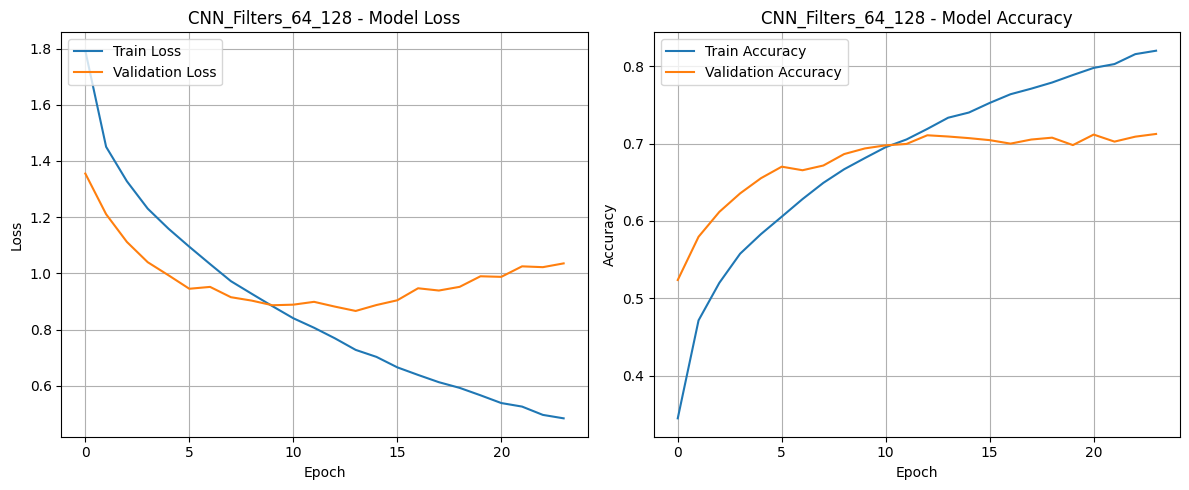

In [14]:
results_num_filters = []
num_conv_layers_for_filters_exp = 2 # Fixed number of layers for this experiment
default_kernel_size = (3,3)
default_pooling = 'max'
# num_classes should be defined

filter_variations = [
    [32, 32],       # e.g., Small filters
    [32, 64],       # Standard increasing
    [64, 128]       # Larger filters
]

all_histories_num_filters = {}

for filters_list in filter_variations:
    model_name = f"CNN_Filters_{'_'.join(map(str, filters_list))}"
    print(f"\nBuilding model: {model_name}")

    model = build_experimental_cnn_model(
        num_conv_layers=num_conv_layers_for_filters_exp,
        filters_list_per_layer=filters_list,
        kernel_size_tuple=default_kernel_size,
        pooling_type=default_pooling,
        num_classes=num_classes
    )

    history, f1_val, f1_test = train_and_evaluate_cnn_model(
        model, X_train_final, y_train_final_int, X_val_final, y_val_final_int, X_test_norm, y_test_int_for_f1,
        model_name, epochs=50, batch_size=64
    )
    plot_training_history(history, model_name, PLOT_SAVE_DIR)

    all_histories_num_filters[model_name] = history
    results_num_filters.append({'name': model_name, 'val_f1': f1_val, 'test_f1': f1_test})

### Experiment: Kernel Size



=== EXPERIMENT: Kernel Size ===

Building model: CNN_Kernel_3x3


Model: "Conv2_Filters32_64_Kernel3_Poolmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: CNN_Kernel_3x3 ---
Epoch 1/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2614 - loss: 2.0133
Epoch 1: val_loss improved from inf to 1.45080, saving model to cnn_models/CNN_Kernel_3x3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2618 - loss: 2.0121 - val_accuracy: 0.4873 - val_loss: 1.4508
Epoch 2/30
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4165 - loss: 1.5834
Epoch 2: val_loss improved from 1.45080 to 1.26547, saving model to cnn_models/CNN_Kernel_3x3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4166 - loss: 1.5830 - val_accuracy: 0.5726 - val_loss: 1.2655
Epoch 3/30
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4713 - loss: 1.4267
Epoch 3: val_loss improved from 1.26547 to 1.16581, saving model to cnn_models/CNN_Kernel_3x3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4714 - loss: 1.4264 - val_accuracy: 0.6011 - val_loss: 1.1658
Epoch 4/30
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5020 - loss: 1.3372
Epoch 4: val_loss improved from 1.16581 to 1.11667, saving model to cnn_models/CNN_Kernel_3x3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5021 - loss: 1.3370 - val_accuracy: 0.6124 - val_loss: 1.1167
Epoch 5/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5258 - loss: 1.2807
Epoch 5: val_loss improved from 1.11667 to 1.04139, saving model to cnn_models/CNN_Kernel_3x3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5258 - loss: 1.2807 - val_accuracy: 0.6316 - val_loss: 1.0414
Epoch 6/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5556 - loss: 1.2012
Epoch 6: val_loss improved from 1.04139 to 1.02814, saving model to cnn_models/CNN_Kernel_3x3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5556 - loss: 1.2012 - val_accuracy: 0.6425 - val_loss: 1.0281
Epoch 7/30
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5743 - loss: 1.1661
Epoch 7: val_loss improved from 1.02814 to 0.99426, saving model to cnn_models/CNN_Kernel_3x3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5743 - loss: 1.1661 - val_accuracy: 0.6591 - val_loss: 0.9943
Epoch 8/30
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5835 - loss: 1.1163
Epoch 8: val_loss improved from 0.99426 to 0.95028, saving model to cnn_models/CNN_Kernel_3x3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5836 - loss: 1.1163 - val_accuracy: 0.6710 - val_loss: 0.9503
Epoch 9/30
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6047 - loss: 1.0733
Epoch 9: val_loss did not improve from 0.95028
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6047 - loss: 1.0734 - val_accuracy: 0.6677 - val_loss: 0.9515
Epoch 10/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6164 - loss: 1.0340
Epoch 10: val_loss improved from 0.95028 to 0.90666, saving model to cnn_models/CNN_Kernel_3x3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6164 - loss: 1.0340 - val_accuracy: 0.6853 - val_loss: 0.9067
Epoch 11/30
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6360 - loss: 1.0005
Epoch 11: val_loss did not improve from 0.90666
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6361 - loss: 1.0003 - val_accuracy: 0.6730 - val_loss: 0.9478
Epoch 12/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6483 - loss: 0.9640
Epoch 12: val_loss did not improve from 0.90666
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6483 - loss: 0.9640 - val_accuracy: 0.6863 - val_loss: 0.9106
Epoch 13/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6662 - loss: 0.9125
Epoch 13: val_loss improved from 0.90666 to 0.90575, saving model to cnn_models/CNN_Kernel_3x3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6662 - loss: 0.9125 - val_accuracy: 0.6873 - val_loss: 0.9057
Epoch 14/30
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6782 - loss: 0.8823
Epoch 14: val_loss improved from 0.90575 to 0.89311, saving model to cnn_models/CNN_Kernel_3x3_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6780 - loss: 0.8826 - val_accuracy: 0.6918 - val_loss: 0.8931
Epoch 15/30
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6853 - loss: 0.8576
Epoch 15: val_loss did not improve from 0.89311
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6853 - loss: 0.8576 - val_accuracy: 0.6934 - val_loss: 0.9138
Epoch 16/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6852 - loss: 0.8434
Epoch 16: val_loss did not improve from 0.89311
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6852 - loss: 0.8434 - val_accuracy: 0.6926 - val_loss: 0.8932
Epoch 17/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7015 - loss: 0.8082
Epoch 17: val_loss did not improve from 0.89311
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7015 - loss: 0.8082 - val_accuracy: 0.6917 - val_loss: 0.9009
Epoch 18/30
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7134 - loss: 0.7802
Epoch 18: val_loss improved from 0.89311

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7133 - loss: 0.7804 - val_accuracy: 0.7030 - val_loss: 0.8904
Epoch 19/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7250 - loss: 0.7495
Epoch 19: val_loss did not improve from 0.89039
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7250 - loss: 0.7496 - val_accuracy: 0.7080 - val_loss: 0.9045
Epoch 20/30
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7263 - loss: 0.7334
Epoch 20: val_loss did not improve from 0.89039
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7263 - loss: 0.7335 - val_accuracy: 0.7053 - val_loss: 0.9235
Epoch 21/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7343 - loss: 0.7042
Epoch 21: val_loss did not improve from 0.89039
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7343 - loss: 0.7043 - val_accuracy: 0.6969 - val_loss: 0.9248
Epoch 22/30
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7442 - loss: 0.6824
Epoch 22: val_loss did not improve from 

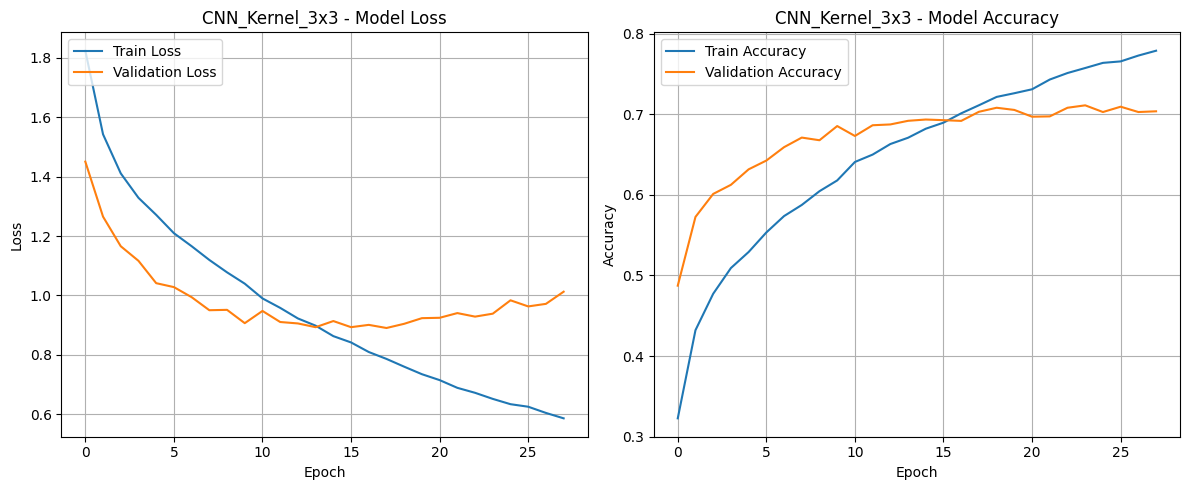


Building model: CNN_Kernel_5x5


Model: "Conv2_Filters32_64_Kernel5_Poolmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,402 (2.21 MB)

 Trainable params: 579,402 (2.21 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: CNN_Kernel_5x5 ---
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2978 - loss: 1.9458
Epoch 1: val_loss improved from inf to 1.33050, saving model to cnn_models/CNN_Kernel_5x5_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2980 - loss: 1.9454 - val_accuracy: 0.5321 - val_loss: 1.3305
Epoch 2/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5098 - loss: 1.3723
Epoch 2: val_loss improved from 1.33050 to 1.13533, saving model to cnn_models/CNN_Kernel_5x5_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5099 - loss: 1.3722 - val_accuracy: 0.5983 - val_loss: 1.1353
Epoch 3/30
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5738 - loss: 1.1985
Epoch 3: val_loss improved from 1.13533 to 1.04573, saving model to cnn_models/CNN_Kernel_5x5_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5738 - loss: 1.1985 - val_accuracy: 0.6388 - val_loss: 1.0457
Epoch 4/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6119 - loss: 1.0981
Epoch 4: val_loss improved from 1.04573 to 0.99891, saving model to cnn_models/CNN_Kernel_5x5_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6119 - loss: 1.0981 - val_accuracy: 0.6570 - val_loss: 0.9989
Epoch 5/30
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6385 - loss: 1.0206
Epoch 5: val_loss improved from 0.99891 to 0.95456, saving model to cnn_models/CNN_Kernel_5x5_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6386 - loss: 1.0206 - val_accuracy: 0.6687 - val_loss: 0.9546
Epoch 6/30
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6682 - loss: 0.9446
Epoch 6: val_loss improved from 0.95456 to 0.91809, saving model to cnn_models/CNN_Kernel_5x5_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6682 - loss: 0.9446 - val_accuracy: 0.6824 - val_loss: 0.9181
Epoch 7/30
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6875 - loss: 0.8849
Epoch 7: val_loss improved from 0.91809 to 0.91416, saving model to cnn_models/CNN_Kernel_5x5_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6875 - loss: 0.8850 - val_accuracy: 0.6832 - val_loss: 0.9142
Epoch 8/30
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7037 - loss: 0.8303
Epoch 8: val_loss improved from 0.91416 to 0.91022, saving model to cnn_models/CNN_Kernel_5x5_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7037 - loss: 0.8304 - val_accuracy: 0.6784 - val_loss: 0.9102
Epoch 9/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7231 - loss: 0.7752
Epoch 9: val_loss improved from 0.91022 to 0.89978, saving model to cnn_models/CNN_Kernel_5x5_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7231 - loss: 0.7752 - val_accuracy: 0.6905 - val_loss: 0.8998
Epoch 10/30
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7354 - loss: 0.7327
Epoch 10: val_loss did not improve from 0.89978
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7353 - loss: 0.7328 - val_accuracy: 0.6936 - val_loss: 0.9059
Epoch 11/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7486 - loss: 0.6901
Epoch 11: val_loss did not improve from 0.89978
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7486 - loss: 0.6901 - val_accuracy: 0.6890 - val_loss: 0.9196
Epoch 12/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7644 - loss: 0.6545
Epoch 12: val_loss did not improve from 0.89978
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7644 - loss: 0.6545 - val_accuracy: 0.6929 - val_loss: 0.9211
Epoch 13/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7765 - loss: 0.6204
Epoch 13: val_loss did not improve from 

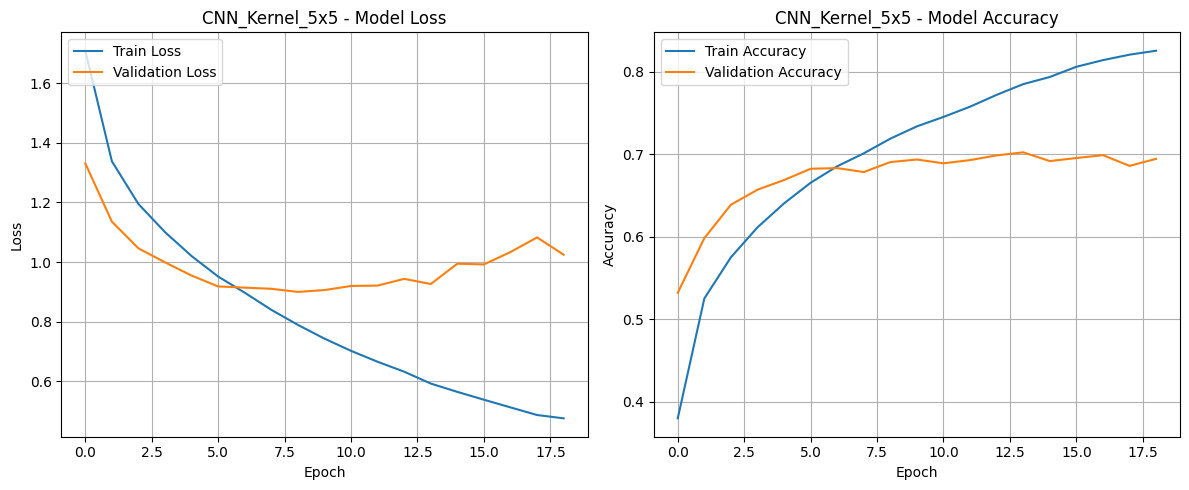


Building model: CNN_Kernel_7x7


Model: "Conv2_Filters32_64_Kernel7_Poolmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 630,858 (2.41 MB)

 Trainable params: 630,858 (2.41 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: CNN_Kernel_7x7 ---
Epoch 1/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2874 - loss: 1.9403
Epoch 1: val_loss improved from inf to 1.36672, saving model to cnn_models/CNN_Kernel_7x7_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2881 - loss: 1.9386 - val_accuracy: 0.5252 - val_loss: 1.3667
Epoch 2/30
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5015 - loss: 1.3971
Epoch 2: val_loss improved from 1.36672 to 1.19015, saving model to cnn_models/CNN_Kernel_7x7_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5016 - loss: 1.3967 - val_accuracy: 0.5826 - val_loss: 1.1902
Epoch 3/30
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5662 - loss: 1.2320
Epoch 3: val_loss improved from 1.19015 to 1.12237, saving model to cnn_models/CNN_Kernel_7x7_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5662 - loss: 1.2318 - val_accuracy: 0.6134 - val_loss: 1.1224
Epoch 4/30
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6050 - loss: 1.1254
Epoch 4: val_loss improved from 1.12237 to 1.01681, saving model to cnn_models/CNN_Kernel_7x7_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6051 - loss: 1.1254 - val_accuracy: 0.6458 - val_loss: 1.0168
Epoch 5/30
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6440 - loss: 1.0216
Epoch 5: val_loss improved from 1.01681 to 0.98616, saving model to cnn_models/CNN_Kernel_7x7_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6440 - loss: 1.0218 - val_accuracy: 0.6530 - val_loss: 0.9862
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6668 - loss: 0.9455
Epoch 6: val_loss did not improve from 0.98616
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6668 - loss: 0.9456 - val_accuracy: 0.6492 - val_loss: 1.0066
Epoch 7/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6860 - loss: 0.8805
Epoch 7: val_loss did not improve from 0.98616
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6860 - loss: 0.8806 - val_accuracy: 0.6575 - val_loss: 0.9935
Epoch 8/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7060 - loss: 0.8302
Epoch 8: val_loss improved from 0.98616 to 0.92589, saving model to cnn_models/CNN_Kernel_7x7_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7059 - loss: 0.8302 - val_accuracy: 0.6819 - val_loss: 0.9259
Epoch 9/30
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7280 - loss: 0.7658
Epoch 9: val_loss did not improve from 0.92589
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7280 - loss: 0.7661 - val_accuracy: 0.6903 - val_loss: 0.9382
Epoch 10/30
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7478 - loss: 0.7073
Epoch 10: val_loss improved from 0.92589 to 0.91784, saving model to cnn_models/CNN_Kernel_7x7_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7477 - loss: 0.7078 - val_accuracy: 0.6874 - val_loss: 0.9178
Epoch 11/30
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7580 - loss: 0.6759
Epoch 11: val_loss did not improve from 0.91784
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7579 - loss: 0.6760 - val_accuracy: 0.6850 - val_loss: 0.9466
Epoch 12/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7775 - loss: 0.6205
Epoch 12: val_loss did not improve from 0.91784
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7774 - loss: 0.6206 - val_accuracy: 0.6855 - val_loss: 0.9594
Epoch 13/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7819 - loss: 0.6043
Epoch 13: val_loss did not improve from 0.91784
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7819 - loss: 0.6044 - val_accuracy: 0.6844 - val_loss: 1.0275
Epoch 14/30
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7974 - loss: 0.5555
Epoch 14: val_loss did not improve from 

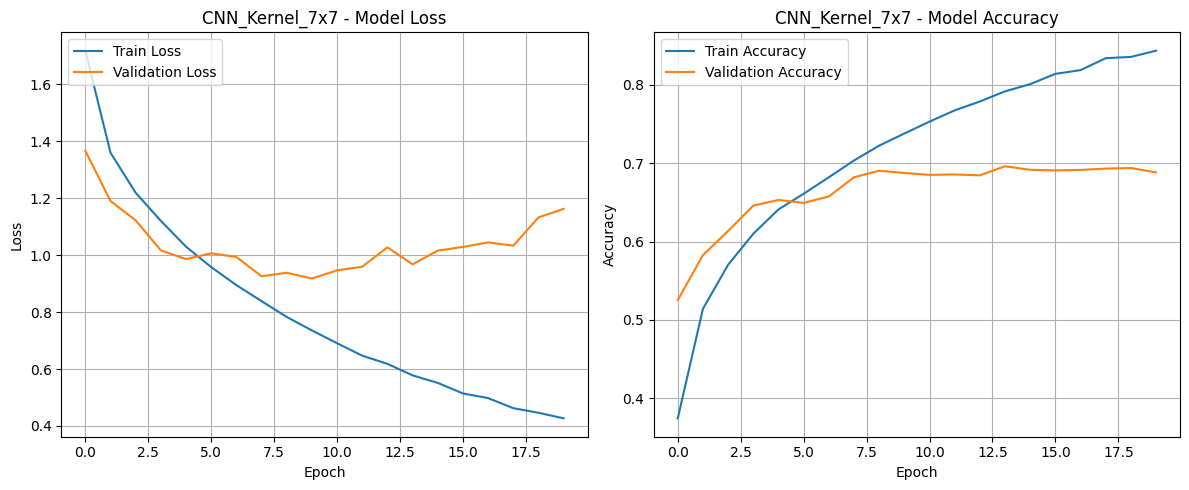

In [15]:
print("\n\n=== EXPERIMENT: Kernel Size ===")
results_kernel_size = []
num_conv_layers_for_kernel_exp = 2
filters_for_kernel_exp = [32, 64] # Fixed filter configuration
default_pooling = 'max'
# num_classes should be defined

kernel_size_variations = [
    (3, 3),
    (5, 5),
    (7, 7) # Be cautious with large kernels on small images like 32x32, might reduce dim too fast or require less pooling
]

all_histories_kernel_size = {}

for kernel_sz in kernel_size_variations:
    model_name = f"CNN_Kernel_{kernel_sz[0]}x{kernel_sz[1]}"
    print(f"\nBuilding model: {model_name}")

    model = build_experimental_cnn_model(
        num_conv_layers=num_conv_layers_for_kernel_exp,
        filters_list_per_layer=filters_for_kernel_exp,
        kernel_size_tuple=kernel_sz,
        pooling_type=default_pooling,
        num_classes=num_classes
    )

    history, f1_val, f1_test = train_and_evaluate_cnn_model(
        model, X_train_final, y_train_final_int, X_val_final, y_val_final_int, X_test_norm, y_test_int_for_f1,
        model_name, epochs=30, batch_size=64
    )
    plot_training_history(history, model_name, PLOT_SAVE_DIR)

    all_histories_kernel_size[model_name] = history
    results_kernel_size.append({'name': model_name, 'val_f1': f1_val, 'test_f1': f1_test})

### Experiment: Pooling Type


Building model: CNN_Pooling_max


Model: "Conv2_Filters32_64_Kernel3_Poolmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: CNN_Pooling_max ---
Epoch 1/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2677 - loss: 2.0135
Epoch 1: val_loss improved from inf to 1.39750, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2679 - loss: 2.0128 - val_accuracy: 0.5038 - val_loss: 1.3975
Epoch 2/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4480 - loss: 1.5029
Epoch 2: val_loss improved from 1.39750 to 1.21004, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4481 - loss: 1.5026 - val_accuracy: 0.5758 - val_loss: 1.2100
Epoch 3/30
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5036 - loss: 1.3526
Epoch 3: val_loss improved from 1.21004 to 1.13132, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5036 - loss: 1.3524 - val_accuracy: 0.6076 - val_loss: 1.1313
Epoch 4/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5411 - loss: 1.2565
Epoch 4: val_loss improved from 1.13132 to 1.05599, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5411 - loss: 1.2565 - val_accuracy: 0.6269 - val_loss: 1.0560
Epoch 5/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5671 - loss: 1.1959
Epoch 5: val_loss improved from 1.05599 to 1.04759, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5671 - loss: 1.1958 - val_accuracy: 0.6305 - val_loss: 1.0476
Epoch 6/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5920 - loss: 1.1294
Epoch 6: val_loss improved from 1.04759 to 0.96375, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5920 - loss: 1.1293 - val_accuracy: 0.6690 - val_loss: 0.9638
Epoch 7/30
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6126 - loss: 1.0775
Epoch 7: val_loss improved from 0.96375 to 0.94958, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6127 - loss: 1.0774 - val_accuracy: 0.6664 - val_loss: 0.9496
Epoch 8/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6282 - loss: 1.0271
Epoch 8: val_loss improved from 0.94958 to 0.93835, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6282 - loss: 1.0271 - val_accuracy: 0.6702 - val_loss: 0.9383
Epoch 9/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6368 - loss: 0.9953
Epoch 9: val_loss improved from 0.93835 to 0.91630, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6368 - loss: 0.9953 - val_accuracy: 0.6820 - val_loss: 0.9163
Epoch 10/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6540 - loss: 0.9534
Epoch 10: val_loss improved from 0.91630 to 0.90516, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6540 - loss: 0.9534 - val_accuracy: 0.6829 - val_loss: 0.9052
Epoch 11/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6627 - loss: 0.9236
Epoch 11: val_loss did not improve from 0.90516
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6626 - loss: 0.9237 - val_accuracy: 0.6818 - val_loss: 0.9137
Epoch 12/30
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6798 - loss: 0.8850
Epoch 12: val_loss did not improve from 0.90516
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6797 - loss: 0.8851 - val_accuracy: 0.6824 - val_loss: 0.9230
Epoch 13/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6856 - loss: 0.8671
Epoch 13: val_loss improved from 0.90516 to 0.89820, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6856 - loss: 0.8670 - val_accuracy: 0.6940 - val_loss: 0.8982
Epoch 14/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6957 - loss: 0.8270
Epoch 14: val_loss did not improve from 0.89820
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6957 - loss: 0.8270 - val_accuracy: 0.6824 - val_loss: 0.9236
Epoch 15/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7027 - loss: 0.8105
Epoch 15: val_loss improved from 0.89820 to 0.89799, saving model to cnn_models/CNN_Pooling_max_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7027 - loss: 0.8105 - val_accuracy: 0.6866 - val_loss: 0.8980
Epoch 16/30
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7153 - loss: 0.7806
Epoch 16: val_loss did not improve from 0.89799
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7153 - loss: 0.7806 - val_accuracy: 0.6962 - val_loss: 0.9012
Epoch 17/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7249 - loss: 0.7403
Epoch 17: val_loss did not improve from 0.89799
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7249 - loss: 0.7404 - val_accuracy: 0.6940 - val_loss: 0.9160
Epoch 18/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7301 - loss: 0.7288
Epoch 18: val_loss did not improve from 0.89799
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7301 - loss: 0.7288 - val_accuracy: 0.7035 - val_loss: 0.8994
Epoch 19/30
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7365 - loss: 0.7085
Epoch 19: val_loss did not improve from 

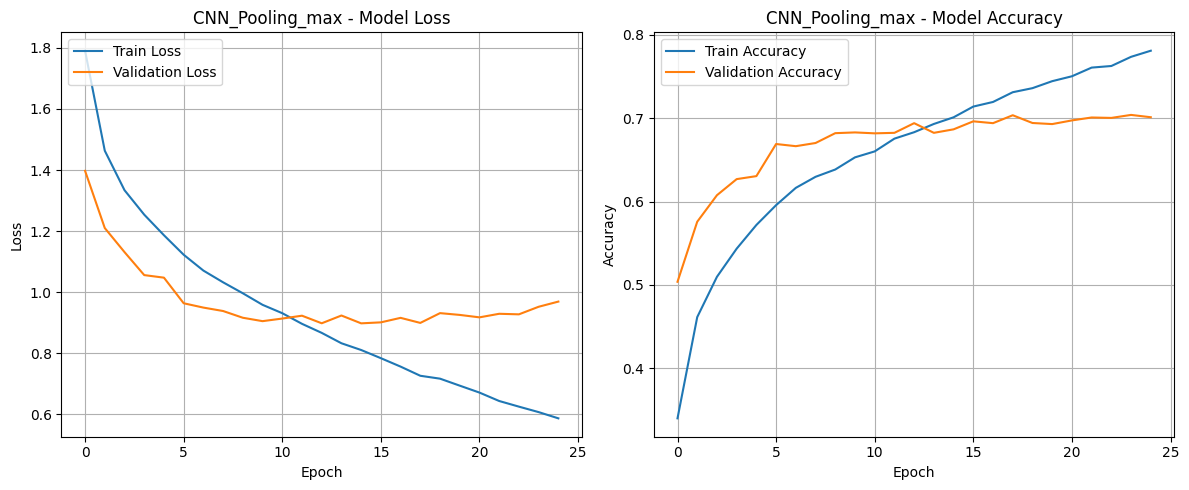


Building model: CNN_Pooling_avg


Model: "Conv2_Filters32_64_Kernel3_Poolavg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool_1 (AveragePooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool_2 (AveragePooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Keras Model: CNN_Pooling_avg ---
Epoch 1/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2934 - loss: 1.9267
Epoch 1: val_loss improved from inf to 1.40123, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2937 - loss: 1.9261 - val_accuracy: 0.5060 - val_loss: 1.4012
Epoch 2/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4572 - loss: 1.4886
Epoch 2: val_loss improved from 1.40123 to 1.24620, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4573 - loss: 1.4885 - val_accuracy: 0.5574 - val_loss: 1.2462
Epoch 3/30
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5096 - loss: 1.3522
Epoch 3: val_loss improved from 1.24620 to 1.16183, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5097 - loss: 1.3520 - val_accuracy: 0.5909 - val_loss: 1.1618
Epoch 4/30
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5478 - loss: 1.2507
Epoch 4: val_loss improved from 1.16183 to 1.08302, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5479 - loss: 1.2506 - val_accuracy: 0.6243 - val_loss: 1.0830
Epoch 5/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5791 - loss: 1.1788
Epoch 5: val_loss improved from 1.08302 to 1.02936, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5791 - loss: 1.1788 - val_accuracy: 0.6333 - val_loss: 1.0294
Epoch 6/30
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 1.1130
Epoch 6: val_loss improved from 1.02936 to 0.99341, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6019 - loss: 1.1129 - val_accuracy: 0.6559 - val_loss: 0.9934
Epoch 7/30
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6213 - loss: 1.0538
Epoch 7: val_loss improved from 0.99341 to 0.96451, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6213 - loss: 1.0538 - val_accuracy: 0.6605 - val_loss: 0.9645
Epoch 8/30
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6379 - loss: 1.0127
Epoch 8: val_loss improved from 0.96451 to 0.92866, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6379 - loss: 1.0127 - val_accuracy: 0.6739 - val_loss: 0.9287
Epoch 9/30
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6570 - loss: 0.9634
Epoch 9: val_loss improved from 0.92866 to 0.92459, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6570 - loss: 0.9636 - val_accuracy: 0.6739 - val_loss: 0.9246
Epoch 10/30
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6635 - loss: 0.9387
Epoch 10: val_loss improved from 0.92459 to 0.90401, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6636 - loss: 0.9388 - val_accuracy: 0.6832 - val_loss: 0.9040
Epoch 11/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6779 - loss: 0.9039
Epoch 11: val_loss improved from 0.90401 to 0.89187, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6779 - loss: 0.9039 - val_accuracy: 0.6873 - val_loss: 0.8919
Epoch 12/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6911 - loss: 0.8598
Epoch 12: val_loss improved from 0.89187 to 0.89079, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6911 - loss: 0.8599 - val_accuracy: 0.6856 - val_loss: 0.8908
Epoch 13/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6946 - loss: 0.8417
Epoch 13: val_loss improved from 0.89079 to 0.88961, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6946 - loss: 0.8417 - val_accuracy: 0.6901 - val_loss: 0.8896
Epoch 14/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7101 - loss: 0.8044
Epoch 14: val_loss improved from 0.88961 to 0.88385, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7101 - loss: 0.8045 - val_accuracy: 0.6918 - val_loss: 0.8838
Epoch 15/30
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7202 - loss: 0.7758
Epoch 15: val_loss did not improve from 0.88385
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7201 - loss: 0.7761 - val_accuracy: 0.6884 - val_loss: 0.8930
Epoch 16/30
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7328 - loss: 0.7494
Epoch 16: val_loss improved from 0.88385 to 0.86289, saving model to cnn_models/CNN_Pooling_avg_best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7327 - loss: 0.7496 - val_accuracy: 0.6991 - val_loss: 0.8629
Epoch 17/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7328 - loss: 0.7390
Epoch 17: val_loss did not improve from 0.86289
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7328 - loss: 0.7390 - val_accuracy: 0.7033 - val_loss: 0.8693
Epoch 18/30
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7426 - loss: 0.7073
Epoch 18: val_loss did not improve from 0.86289
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7425 - loss: 0.7074 - val_accuracy: 0.6991 - val_loss: 0.8746
Epoch 19/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7507 - loss: 0.6860
Epoch 19: val_loss did not improve from 0.86289
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7507 - loss: 0.6861 - val_accuracy: 0.7023 - val_loss: 0.8653
Epoch 20/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7541 - loss: 0.6685
Epoch 20: val_loss did not improve from 

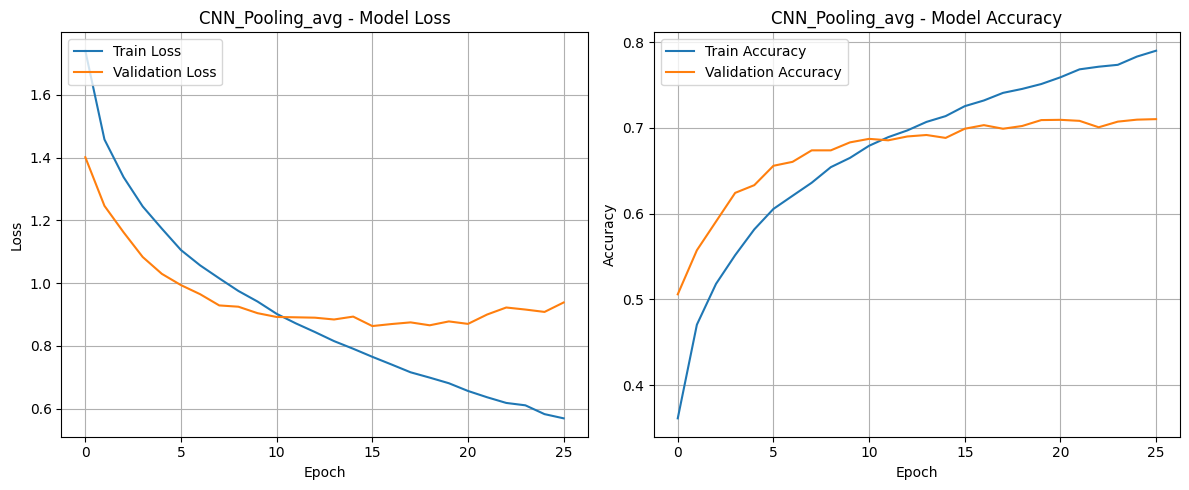

In [16]:
results_pooling_type = []
num_conv_layers_for_pooling_exp = 2
filters_for_pooling_exp = [32, 64]
kernel_size_for_pooling_exp = (3,3)

pooling_variations = ['max', 'avg']
all_histories_pooling = {}

for pool_type in pooling_variations:
    model_name = f"CNN_Pooling_{pool_type}"
    print(f"\nBuilding model: {model_name}")

    model = build_experimental_cnn_model(
        num_conv_layers=num_conv_layers_for_pooling_exp,
        filters_list_per_layer=filters_for_pooling_exp,
        kernel_size_tuple=kernel_size_for_pooling_exp,
        pooling_type=pool_type,
        num_classes=num_classes
    )

    history, f1_val, f1_test = train_and_evaluate_cnn_model(
        model, X_train_final, y_train_final_int, X_val_final, y_val_final_int, X_test_norm, y_test_int_for_f1,
        model_name, epochs=30, batch_size=64
    )
    plot_training_history(history, model_name, PLOT_SAVE_DIR)

    all_histories_pooling[model_name] = history
    results_pooling_type.append({'name': model_name, 'val_f1': f1_val, 'test_f1': f1_test})

## Forward Pass Comparison

We will compare the keras forward propagation implementation with our own forward propagation implementation on two models:
1. AlexNet-like model
2. CNN model which was trained using average pooling

This is done to demonstrate the correctness of our own forward propagation implementation in all layers.

To save time, we will evaluate on 700 instances of test data only

### Imports

In [71]:
model_filepath_to_load = f"../bin/cnn_models/AlexNetLike_CIFAR10_Sparse_Baseline_best_model.h5"
model_filepath_to_load_2 = f"../bin/cnn_models/CNN_Pooling_avg_best_model.h5"
NUM_CLASSES=10

In [77]:
import importlib
import sys

# --- Modules to Reload ---
module_paths = {
    "LayerBase": "layers.layer",
    "Conv2D": "layers.conv2d",
    "Sequential": "sequential",
    "MaxPooling2D": "layers.pooling",
    "Flatten": "layers.flatten",
    "Dense": "layers.dense",
    "Dropout": "layers.dropout",
}

print("--- Attempting to Reload Modules ---")
for logical_name, module_path_str in module_paths.items():
    if module_path_str in sys.modules:
        try:
            # Get the actual module object from sys.modules
            module_to_reload = sys.modules[module_path_str]
            importlib.reload(module_to_reload)
            print(f"Successfully reloaded: {module_path_str} (as {logical_name})")
        except Exception as e:
            print(f"Error reloading {module_path_str}: {e}")
    else:
        print(f"Module {module_path_str} not in sys.modules. Will attempt fresh import.")


--- Attempting to Reload Modules ---
Successfully reloaded: layers.layer (as LayerBase)
Successfully reloaded: layers.conv2d (as Conv2D)
Successfully reloaded: sequential (as Sequential)
Successfully reloaded: layers.pooling (as MaxPooling2D)
Successfully reloaded: layers.flatten (as Flatten)
Successfully reloaded: layers.dense (as Dense)
Successfully reloaded: layers.dropout (as Dropout)


In [78]:
from sequential import Sequential
from layers.dense import Dense
from layers.conv2d import Conv2D
from layers.flatten import Flatten
from layers.pooling import MaxPooling2D, AveragePooling2D
from layers.dropout import Dropout

In [67]:
np.random.seed(42)
random_indices = np.random.choice(10000, size=700, replace=False)

X_sample = X_test_norm[random_indices]
y_sample = y_test_int_for_f1[random_indices]

### AlexNet-Like

In [50]:
custom_cnn_1 = Sequential([
    Conv2D(48, (5, 5), strides=(1,1), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2,2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2,2)),
    Conv2D(192, (3, 3), activation='relu', padding='same'),
    Conv2D(192, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(),
    Dense(128, activation='relu'),
    Dropout(),
    Dense(NUM_CLASSES, activation='softmax')
])

In [51]:
custom_cnn_1.load_weights(model_filepath_to_load)

HDF5 layer keys: ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'dense_1', 'dense_2', 'dense_output', 'dropout_1', 'dropout_2', 'flatten', 'maxpool_1', 'maxpool_2', 'maxpool_3', 'top_level_model_weights']
Loading 2 weight array(s) into layer 0 (type: Conv2D, key: conv2d_1)
Loading 0 weight array(s) into layer 1 (type: MaxPooling2D, key: maxpool_1)
Error loading weights for custom layer 1 (key='maxpool_1'): Load Keras weights method not implemented
Skipped loading weights for custom layer 1 (original key='maxpool', resolved='maxpool_1')
Loading 2 weight array(s) into layer 2 (type: Conv2D, key: conv2d_2)
Loading 0 weight array(s) into layer 3 (type: MaxPooling2D, key: maxpool_2)
Error loading weights for custom layer 3 (key='maxpool_2'): Load Keras weights method not implemented
Skipped loading weights for custom layer 3 (original key='maxpool', resolved='maxpool_2')
Loading 2 weight array(s) into layer 4 (type: Conv2D, key: conv2d_3)
Loading 2 weight array(s) into layer 5

In [54]:
keras_model_1 = tf.keras.models.load_model(model_filepath_to_load)
keras_model_1.summary()

Model: "AlexNetLike_CIFAR10_Sparse"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 48)     │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 192)      │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,392,460 (5.31 MB)

 Trainable params: 1,392,458 (5.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [61]:
def evaluate_macro_f1(y_true, y_pred, dataset_name="Validation"):
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1-score on {dataset_name} set: {macro_f1:.4f}")
    return macro_f1

In [68]:
y_test_pred_probs = keras_model_1.predict(X_sample)
y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)

evaluate_macro_f1(y_sample, y_test_pred_classes, "Keras Model Test")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Macro F1-score on Keras Model Test set: 0.7229


0.7229072374222533

In [69]:
y_test_pred_probs_custom = custom_cnn_1.predict(X_sample)
y_test_pred_classes_custom = np.argmax(y_test_pred_probs_custom, axis=1)

evaluate_macro_f1(y_sample, y_test_pred_classes_custom, "Custom Model Test")

Macro F1-score on Custom Model Test set: 0.7229


0.7229072374222533

### Average Pooling Model

In [79]:
custom_cnn_2 = Sequential([
    Conv2D(32, (3, 3), strides=(1,1), activation='relu', padding='same'),
    AveragePooling2D((2, 2), strides=(2,2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    AveragePooling2D((2, 2), strides=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(),
    Dense(NUM_CLASSES, activation='softmax')
])

In [80]:
custom_cnn_2.load_weights(model_filepath_to_load_2)

HDF5 layer keys: ['avgpool_1', 'avgpool_2', 'conv2d_1', 'conv2d_2', 'dense_128', 'dense_output', 'dropout_fc', 'flatten', 'top_level_model_weights']
Loading 2 weight array(s) into layer 0 (type: Conv2D, key: conv2d_1)
Loading 0 weight array(s) into layer 1 (type: AveragePooling2D, key: avgpool_1)
Pooling has no trainable weights — skipping
Loading 2 weight array(s) into layer 2 (type: Conv2D, key: conv2d_2)
Loading 0 weight array(s) into layer 3 (type: AveragePooling2D, key: avgpool_2)
Pooling has no trainable weights — skipping
Loading 0 weight array(s) into layer 4 (type: Flatten, key: flatten)
Flatten has no trainable weights — skipping
Loading 2 weight array(s) into layer 5 (type: Dense, key: dense_128)
No matching group in file for layer key base 'dropout'
Loading 2 weight array(s) into layer 7 (type: Dense, key: dense_output)


In [73]:
keras_model_2 = tf.keras.models.load_model(model_filepath_to_load_2)
keras_model_2.summary()

Model: "Conv2_Filters32_64_Kernel3_Poolavg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool_1 (AveragePooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool_2 (AveragePooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,100 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [81]:
y_test_pred_probs_2 = keras_model_2.predict(X_sample)
y_test_pred_classes_2 = np.argmax(y_test_pred_probs_2, axis=1)

evaluate_macro_f1(y_sample, y_test_pred_classes_2, "Keras Model Test")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Macro F1-score on Keras Model Test set: 0.6595


0.659501962912084

In [83]:
y_test_pred_probs_custom_2 = custom_cnn_2.predict(X_sample)
y_test_pred_classes_custom_2 = np.argmax(y_test_pred_probs_custom_2, axis=1)

evaluate_macro_f1(y_sample, y_test_pred_classes_custom_2, "Custom Model Test")

Macro F1-score on Custom Model Test set: 0.6595


0.659501962912084